In [23]:
import numpy as np
import matplotlib.pyplot as plt

from hercules.python_simulators.simple_battery import SimpleBattery


In [24]:
batt_dict = {
    "py_sim_type": SimpleBattery,
    "size": 20,  # MW size of the battery
    "energy_capacity": 1,  # total capcity of the battery in MWh (4-hour 20 MW battery)
    "charge_rate": 2,  # charge rate of the battery in MW
    "discharge_rate": 2,  # discharge rate of the battery in MW
    "max_SOC": 0.9,  # upper boundary on battery SOC
    "min_SOC": 0.1,  # lower boundary on battery SOC
    "initial_conditions": {
        "SOC": 0.5  # initial state of charge of the battery in percentage of total size
    },
}
dt = 0.5
SB = SimpleBattery(batt_dict, dt)

In [25]:
time_start = 0
time_end = 3 * 3600
time_delta = dt
time = np.arange(time_start, time_end, time_delta)

def simulate(SB, time, available_power, signal):
    inputs = {"controller": {"signal": 0}, "py_sims": {"inputs": {"available_power": 0}}}
    batt_power = np.zeros(len(time))
    batt_reject = np.zeros(len(time))
    batt_soc = np.zeros(len(time))

    for i in range(len(time)):
        inputs["controller"]["signal"] = signal[i]
        inputs["py_sims"]["inputs"]["available_power"] = available_power[i]
        outputs = SB.step(inputs)
        batt_power[i] = outputs["power"]
        batt_reject[i] = outputs["reject"]
        batt_soc[i] = outputs["soc"]

    fig, ax = plt.subplots(3, 1, sharex="col", figsize=(12, 8))

    ax[0].plot(time, available_power, label="P_avail")
    ax[0].plot(time, signal, linestyle="dashed", label="Signal")
    # ax[0].plot(time, available_power - batt_power, linestyle="dotted", label="P_down_batt")
    # ax[0].plot(time, batt_reject, linestyle="dashdot", label="P_down_cont")
    ax[0].legend()
    ax[0].set_ylabel("Power [kW]")


    ax[1].hlines(
        [batt_dict["charge_rate"] * 1e3, -batt_dict["discharge_rate"] * 1e3],
        time_start,
        time_end,
        alpha=0.5,
        linewidth=0.5,
        color="black",
    )


    ax[1].plot(time, batt_power, label="P_batt")
    ax[1].plot(time, batt_reject, linestyle="dashed", label="P_reject")
    ax[1].legend()
    ax[1].set_ylim(
        [-1.5 * batt_dict["discharge_rate"] * 1e3, 1.5 * batt_dict["charge_rate"] * 1e3]
    )
    ax[1].set_ylabel("Power [kW]")

    ax[2].hlines(
        [batt_dict["min_SOC"], batt_dict["max_SOC"]],
        time_start,
        time_end,
        alpha=0.5,
        linewidth=0.5,
        color="black",
    )

    ax[2].plot(time, batt_soc, label="SOC")
    ax[2].legend()
    ax[2].set_ylabel("SOC")
    ax[2].set_xlabel("Time [s]")

## State of Charge limits

The battery obeys its state of charge limits when asked to charge or discharge too much.

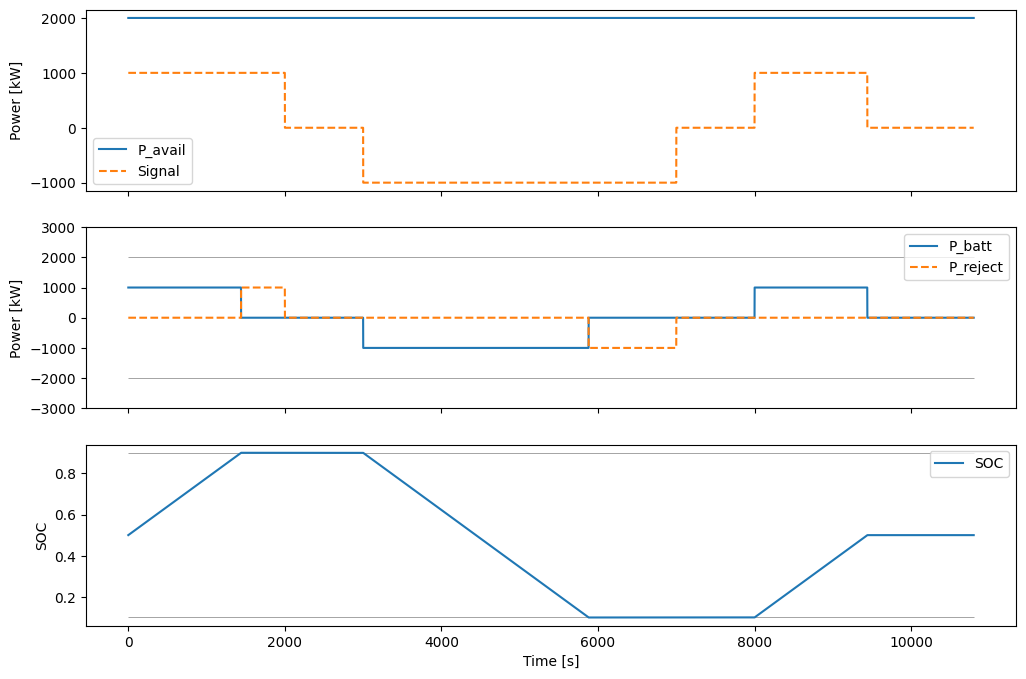

In [26]:
SB.E = 0.5  * 1e3 * 3600

available_power = 2e3 * np.ones(len(time))
signal = np.concatenate([
    1e3 * np.ones(4000),
    np.zeros(2000),
    -1e3*np.ones(8000),
    np.zeros(2000),
    1e3 * np.ones(2880),
    np.zeros(len(time)-16000 - 2880)
])

simulate(SB, time, available_power, signal)

## Charging/Discharging rate limits

The battery obeys its charging/discharging limits when asked to charge or discharge more too rapidly.

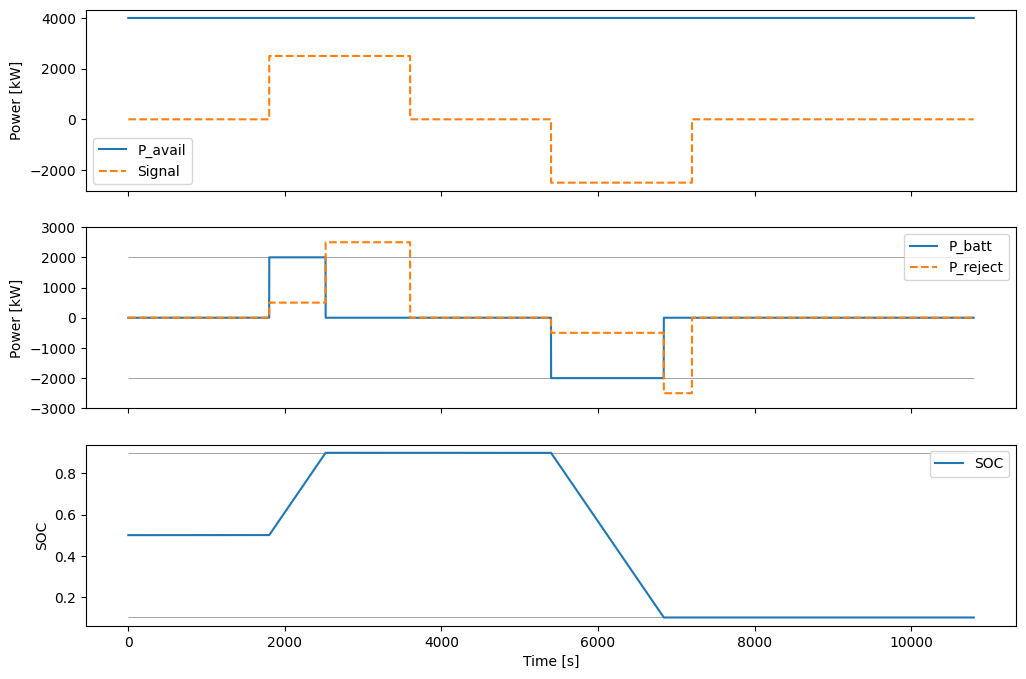

In [27]:
SB.E = 0.5  * 1e3 * 3600

available_power = 4e3 * np.ones(len(time))
signal = np.concatenate([
    np.zeros(3600),
    2.5e3 * np.ones(3600),
    np.zeros(3600),
    -2.5e3 * np.ones(3600),
    np.zeros(2*3600)
])

simulate(SB, time, available_power, signal)

## Other limits

The battery does not charge with more than the available power even when signaled to do so.

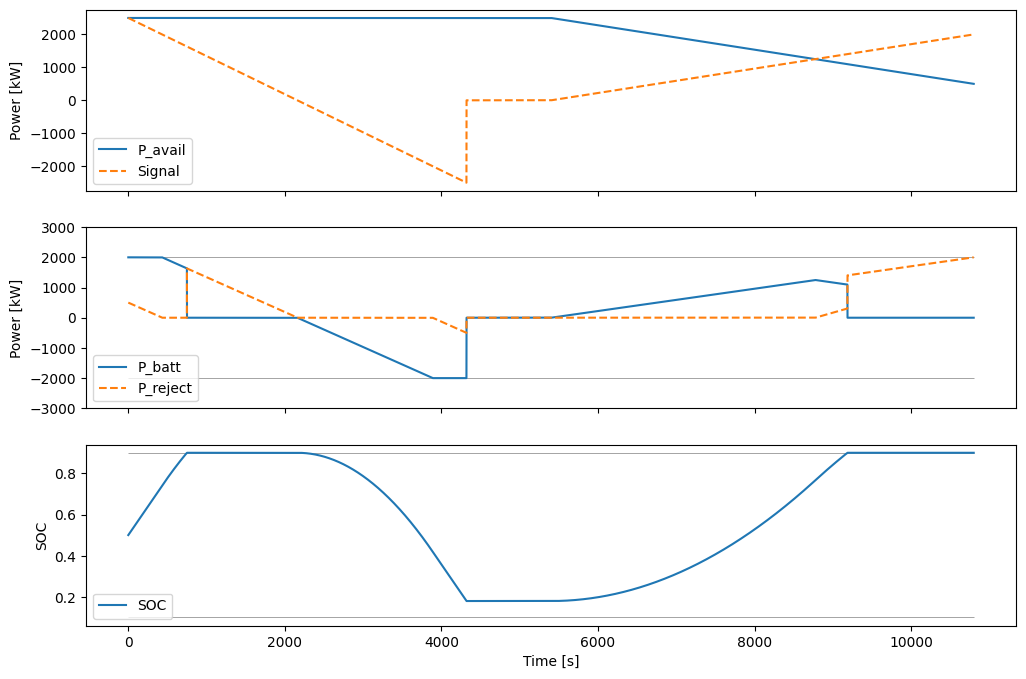

In [28]:
SB.E = 0.5  * 1e3 * 3600
available_power = 2.5e3 * np.ones(len(time)) + np.concatenate(
    [np.zeros(int((1 - 0.5) * len(time))), np.linspace(0, -2e3, int(0.5 * len(time)))]
)

signal = np.concatenate(
    [
        np.linspace(2.5e3, -2.5e3, int(0.4 * len(time))),
        np.zeros(int((1 - 0.4) * len(time))),
    ]
) + np.concatenate(
    [np.zeros(int((1 - 0.5) * len(time))), np.linspace(0, 2e3, int(0.5 * len(time)))]
)

simulate(SB, time, available_power, signal)